In [31]:
import nrrd
import pandas as pd
import numpy as np
from voxcell import RegionMap
import re
import multiprocessing as mp


import sys
sys.path.append('/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/notebooks/scripts/')

from helper_functions import get_all_filenames, get_csv_filenames, extract_prefix_from_filenames
from helper_functions import read_and_test_csv_files
from helper_functions import read_and_concat_csv_files_new, combine_rows_and_calculate_average, create_combined_dataframe

# Create NRRD files for: 
In order to run Blue Brain's current validation script, we require computed nrrd files for certain cell groups. It is **critical** to create the nrrd files with the template you use for comparison. E.g.: vanilla CCFv3 will give slightly different densities than CCFv3_0 and quite different than CCFv3a since that has extra brain regions in the OLF bulb and the Cerebellum, Medulla. In other words: ```brain_regions = '/gpfs/bbp.cscs.ch/data/project/proj84/piluso/share/general/warped_augmented_CCFv3/annotation_25_2022_CCFv3_0.nrrd' ``` should be the same in both parts of the code. 

- total cell, total neuron, total glia, total sum of inhibitory + excitatory neuron densities, total excitatory neuron density, total inhibitory neuron densities, total sum of glia density subtypes, total astrocyte densities, 
total microglia densities, total oligodendrocyte density
- total sst densities, total pv densities, total vip density, total rest_inhib density
- fiber tracks + grooves + ventricular_system where no neuron should be found

**Cell types that don't fit in the current pipeline:**
CHOR, choroid plexus Endo, endothelial cells SMC, smooth muscle cells VLMC, vascular leptomeningeal cells ABC, arachnoid barrier cells BAM, border-associated macrophages Ependymal, hypendymal cells, tanycytes, Astroependymal

- **Astrocytes** (5): Astro-OLF, Astro-TE (for telencephalon), Astro-NT (for non-telencephalon), Astro-CB and Bergmann glia
- **Oligos or OPC–Oligo** (4): oligodendrocyte precursors (COP), newly formed oligodendrocytes (NFOL), myelin-forming oligodendrocytes (MFOL), and mature oligodendrocytes (MOL)
- **OEC** class corresponds to olfactory ensheathing cells (OEC)
- **Vascular class** (5): arachnoid barrier cells (ABC), vascular leptomeningeal cells (VLMC), pericytes (Peri), smooth muscle cells (SMC) and endothelial cells (Endo)
- **Immune** (5): __microglia__, border-associated macrophages (BAM), monocytes, dendritic cells (DC) and lymphoid cells (which contains B cells, T cells, natural killer (NK) cells and innate lymphoid cells (ILC))

In [2]:
#Read CCFv3 annotation volumes (choose 1)
# data_folder = "/gpfs/bbp.cscs.ch/project/proj84/piluso/share/general/warped_augmented_CCFv3/"
# CCFv3_0, _ = nrrd.read(f'{data_folder}annotation_25_2022_CCFv3_0.nrrd')

# data_folder = "/gpfs/bbp.cscs.ch/data/project/proj62/csaba/atlas/bbp_prod_files/2022/"
# CCFv3_0, _ = nrrd.read(f'{data_folder}annotation_25.nrrd')

data_folder = "/gpfs/bbp.cscs.ch/project/proj84/piluso/share/general/warped_augmented_CCFv3/"
CCFv3_0, _ = nrrd.read(f'{data_folder}annotation_25_2022_CCFv3a.nrrd')

# CCFv3_0, _ = nrrd.read("/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/annotation_ccfv3_l23split_barrelsplit_validated.nrrd")

# Create float copy of the annotation voluem, update values in CCFv3_0 based on conditions
CCFv3_0_copy = np.copy(CCFv3_0).astype('float64')

In [3]:
meta_path = "/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/metadata/WMB-10X/20231215/views/cell_metadata_with_cluster_annotation.csv"
metadata = pd.read_csv(meta_path, dtype={'cell_label':str})
metadata = metadata[['class', 'subclass', 'cluster']]

n_classes = ['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
       '04 DG-IMN Glut', '05 OB-IMN GABA', '06 CTX-CGE GABA',
       '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
       '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '13 CNU-HYa Glut',
       '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
       '18 TH Glut', '19 MB Glut', '20 MB GABA', '21 MB Dopa',
       '22 MB-HB Sero', '23 P Glut', '24 MY Glut', '25 Pineal Glut',
       '26 P GABA', '27 MY GABA', '28 CB GABA', '29 CB Glut',]

nn_classes = ['30 Astro-Epen', '31 OPC-Oligo', '32 OEC', '33 Vascular',
       '34 Immune']

exc = ['01 IT-ET Glut', '02 NP-CT-L6b Glut', '03 OB-CR Glut',
      '04 DG-IMN Glut', '13 CNU-HYa Glut', '14 HY Glut', '15 HY Gnrh1 Glut', '16 HY MM Glut', '17 MH-LH Glut',
      '18 TH Glut', '19 MB Glut', '23 P Glut', '24 MY Glut', '25 Pineal Glut', '29 CB Glut',]
inh = ['05 OB-IMN GABA', '06 CTX-CGE GABA', '07 CTX-MGE GABA', '08 CNU-MGE GABA', '09 CNU-LGE GABA',
      '10 LSX GABA', '11 CNU-HYa GABA', '12 HY GABA', '20 MB GABA', '26 P GABA', '27 MY GABA', '28 CB GABA', ]
other = ['21 MB Dopa', '22 MB-HB Sero', ]
exci_inhib_sum = exc + inh

astrotypes = ['5206 Bergmann NN_1', '5207 Astro-CB NN_1', '5208 Astro-NT NN_1',
       '5209 Astro-NT NN_1', '5210 Astro-NT NN_1', '5211 Astro-NT NN_1',
       '5212 Astro-NT NN_1', '5213 Astro-NT NN_1', '5214 Astro-NT NN_2',
       '5215 Astro-NT NN_2', '5216 Astro-NT NN_2', '5217 Astro-NT NN_2',
       '5218 Astro-TE NN_1', '5219 Astro-TE NN_1', '5220 Astro-TE NN_1',
       '5221 Astro-TE NN_1', '5222 Astro-TE NN_2', '5223 Astro-TE NN_2',
       '5224 Astro-TE NN_3', '5225 Astro-TE NN_3', '5226 Astro-TE NN_3',
       '5227 Astro-TE NN_3', '5228 Astro-TE NN_4', '5229 Astro-TE NN_5',
       '5230 Astro-TE NN_5', '5231 Astro-OLF NN_1', '5232 Astro-OLF NN_1',
       '5233 Astro-OLF NN_2', '5234 Astro-OLF NN_2',
       '5235 Astro-OLF NN_3', '5236 Astro-OLF NN_3',]

microglia = ['5312 Microglia NN_1']

oligos = [ '5266 OPC NN_1', '5267 OPC NN_1',
       '5268 OPC NN_1', '5269 OPC NN_1', '5270 OPC NN_1', '5271 OPC NN_2',
       '5272 COP NN_1', '5273 COP NN_1', '5274 COP NN_1', '5275 COP NN_1',
       '5276 COP NN_1', '5277 COP NN_1', '5278 NFOL NN_2',
       '5279 NFOL NN_2', '5280 NFOL NN_2', '5281 NFOL NN_2',
       '5282 MFOL NN_3', '5283 MFOL NN_3', '5284 MOL NN_4',
       '5285 MOL NN_4', '5286 MOL NN_4', '5287 MOL NN_4', '5288 MOL NN_4',]

glia = astrotypes + microglia + oligos

neurontypes = np.unique(metadata[metadata['class'].isin(n_classes)]['cluster'].values)
nonneurontypes = np.unique(metadata[metadata['class'].isin(nn_classes)]['cluster'].values)
exctypes = np.unique(metadata[metadata['class'].isin(exc)]['cluster'].values)
inhtypes = np.unique(metadata[metadata['class'].isin(inh)]['cluster'].values)
othertypes = np.unique(metadata[metadata['class'].isin(other)]['cluster'].values)
exci_inhib_sum = np.unique(metadata[metadata['class'].isin(exci_inhib_sum)]['cluster'].values)
celltypes = np.unique(metadata['cluster'].values)

/gpfs/bbp.cscs.ch/data/project/proj62/csaba/env/cell2loc_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
file = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/metadata/parcellation_to_parcellation_term_membership_extend.csv'
parcellation_annotation = pd.read_csv(file)

#instead: here we just filter for all substructures in the df
substructures = parcellation_annotation[parcellation_annotation['parcellation_term_set_name'] == 'substructure']

In [6]:
root_folder = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/'

In [7]:
#Load all csv files with densities
folder_path = f'{root_folder}csv/'
filenames = get_all_filenames(folder_path)
csv_filenames = get_csv_filenames(folder_path)
prefixes = extract_prefix_from_filenames(csv_filenames)
unique_prefixes = sorted(list(set(prefixes)))
print(len(csv_filenames), len(prefixes), len(unique_prefixes), )
read_and_test_csv_files(csv_filenames, unique_prefixes, folder_path)

703 703 703
If there are no print messages before this, all DataFrames / csv files contains cells and densities


In [8]:
for pref in unique_prefixes:
    region_info = substructures[substructures['cluster_as_filename'] == pref]
    if region_info.shape[0] != 1:
        if region_info.shape[0] == 0:
            print(pref , " region was not found among substructures!", flush=True)
        else:
            print(pref , region_info.parcellation_term_name.values[0], region_info.shape[0], " region is ambiguous!", flush=True)

fa corpus callosum, anterior forceps 2  region is ambiguous!
icp inferior cerebellar peduncle 2  region is ambiguous!
sV sensory root of the trigeminal nerve 2  region is ambiguous!
scp superior cerebelar peduncles 4  region is ambiguous!
st stria terminalis 2  region is ambiguous!


### continute
- The next cell will list unique leaf regions introduced by Sebastien. Vanilla CCFV3 show anything. 

In [9]:
#region_map_path ='/gpfs/bbp.cscs.ch/project/proj62/csaba/atlas/bbp_prod_files/1.json'
region_map_path ='/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/hierarchy_ccfv3_l23split_barrelsplit.json'
region_map = RegionMap.load_json(region_map_path)

all_leaves = np.unique(CCFv3_0)
missing_leaves = []
for leaf in all_leaves:
    annotation_id_info = substructures[substructures['label_numbers']== leaf]
    if annotation_id_info.shape[0] == 0:
        name = region_map.get(leaf, "name", with_ascendants=False)
        print(leaf, name, " region was not found among substructures!", flush=True)
        missing_leaves.append(leaf)
    elif annotation_id_info.shape[0] == 1:
        None
    else:
        print(regionname, annotation_id_info.shape[0], "interesting", flush=True)

In [10]:
%%time
#Create a dict of df, each containing a cell type's occurence in all regions and its densities in all regions
result_dataframes = read_and_concat_csv_files_new(csv_filenames, unique_prefixes, folder_path) #[region]celltypes
combined_result_dataframes = combine_rows_and_calculate_average(result_dataframes)
shuffled_combined_dataframes = create_combined_dataframe(combined_result_dataframes) #[celltypes]region


CPU times: user 43.2 s, sys: 57.1 ms, total: 43.3 s
Wall time: 43.3 s


- neuron = 'all neuron types densities'
- nonneuron = 'all non neuron densities'
- exc, inh
- glia = astro + oligo + micro

In [11]:
def nrrd_for_validation(df, parcellation_annotation, CCFv3_0):
    all_ids_for_df = []
    df_comb = pd.DataFrame()

    for regionname in df.index.values[0:]:
        density = df.loc[regionname][0]
        #annotation_id_info = substructures[substructures['cluster_as_filename'] == regionname]
        annotation_id_info = parcellation_annotation[parcellation_annotation['cluster_as_filename'] == regionname]

        Annotation2020ids = [int(re.search(r'\d+$', s).group()) for s in annotation_id_info['parcellation_label'].values]
        df_sub = pd.DataFrame({'density': density}, index=Annotation2020ids)
        df_comb = pd.concat([df_comb, df_sub])
        all_ids_for_df.append(Annotation2020ids)

    all_ids_for_df = [value for sublist in all_ids_for_df for value in sublist]
    all_ids_for_df.append(0)
    #Place to put extra regions not part of Allen's Parcellation annotation

    outside = 0
    outsideid = [0]
    df_sub = pd.DataFrame({'density': outside}, index=outsideid)
    df_comb = pd.concat([df_comb, df_sub])

    CCFv3_0_copy = CCFv3_0.copy()

    # Expression is 0 in those regions where we don't have any info:
    CCFv3_0_copy[~np.isin(CCFv3_0_copy, all_ids_for_df)] = 0.0 

    # Expression is non-zero in these leaf region(s)
    for index, row in df_comb.iterrows():
        density_value = row['density']
        region_id = index
        CCFv3_0_copy[np.isin(CCFv3_0, region_id)] = density_value

    #Create outside of the brain as 0
    CCFv3_0_copy[np.isin(CCFv3_0, int(0))] = 0

    return CCFv3_0_copy

One more time, together:

In [12]:
%%time

def process_type(types, file_name):
    # Filter DataFrames based on types
    filtered_dataframes = {key: value for key, value in shuffled_combined_dataframes.items() if key in types}
    
    # Combine filtered DataFrames
    combined_df = pd.concat(filtered_dataframes.values())
    
    # Sum the combined DataFrame by index
    summed_df = combined_df.groupby(combined_df.index).sum()
    
    # Validate result
    result = nrrd_for_validation(summed_df, parcellation_annotation, CCFv3_0)
    
    # Clean up
    del combined_df, summed_df, filtered_dataframes
    
    return (result, file_name)

def main():
    # Define the parameters for each process
    tasks = [
        (neurontypes, "total_neuron_densities"),
        (nonneurontypes, "total_nonneuron_densities"),
        (exctypes, "total_excitatory_densities"),
        (inhtypes, "total_inhibitory_densities"),
        (astrotypes, "total_astrotypes_densities"),
        (microglia, "total_microglia_densities"),
        (oligos, "total_oligocyte_densities"),
        (glia, "total_glia_densities"),
        (exci_inhib_sum, "total_excinh_densities"),
        (celltypes, "total_celltypes_densities"),
    ]
    
    # Create a multiprocessing Pool
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(process_type, tasks)
    
    # Sequentially write the .nrrd files to avoid concurrent writes
    for result, file_name in results:
        nrrd.write(f"{root_folder}{file_name}.nrrd", result)

if __name__ == "__main__":
    main()

CPU times: user 1min 15s, sys: 4.93 s, total: 1min 20s
Wall time: 9min 15s


# Sebastien Validation from here

In [13]:
import numpy as np
from voxcell import VoxelData
from voxcell.nexus.voxelbrain import RegionMap
from argparse import ArgumentParser
import os, sys
import warnings
import inspect


In [14]:
# Parse arguments

parser = ArgumentParser()
parser.add_argument("annotation")
parser.add_argument("hierarchy")
parser.add_argument("density_folder")
parser.add_argument("cell_density")
parser.add_argument("inhibitory_density_folder")
parser.add_argument("excitatory_ME_types_folder")
parser.add_argument("inhibitory_ME_types_folder")
parser.add_argument("excitatory_ME_types_transplant_folder")
parser.add_argument("inhibitory_ME_types_transplant_folder")


_StoreAction(option_strings=[], dest='inhibitory_ME_types_transplant_folder', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

In [15]:
#brain_regions = '/gpfs/bbp.cscs.ch/home/veraszto/bbp_prod_files/2022/annotation_25.nrrd'
brain_regions = '/home/piluso/data/00_allen_brain_atlas/ccfv2/annotation_25_ccfv2_combined.nrrd '


hierarchy_json = '/gpfs/bbp.cscs.ch/home/veraszto/bbp_prod_files/1.json'
#cell_density = '/gpfs/bbp.cscs.ch/home/veraszto/leaves_only/cell_densities_correctednissl/neuron_density.nrrd'
cell_density = '/gpfs/bbp.cscs.ch/home/piluso/cell_atlas/03_warped_annotation_fix_last/blue_brain_atlas_pipeline/leaves_only/overall_cell_density_correctednissl_validated.nrrd'
#cell_density = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/total_celltypes_densities.nrrd'
density_folder = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/'

In [16]:
_

OrderedDict([('type', 'uint32'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([566, 320, 456])),
             ('space directions',
              array([[25.,  0.,  0.],
                     [ 0., 25.,  0.],
                     [ 0.,  0., 25.]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin', array([0., 0., 0.]))])

## Literature

In [17]:
print("\nRegion filters setting")
region_map = RegionMap.load_json(hierarchy_json)

cerebellum = region_map.find(
        "Cerebellum", attr="name", with_descendants=True
    ) | region_map.find("arbor vitae", attr="name", with_descendants=True)

isocortex = (
    region_map.find("Isocortex", attr="name", with_descendants=True)
    | region_map.find("Entorhinal area", attr="name", with_descendants=True)
    | region_map.find("Piriform area", attr="name", with_descendants=True)
)
fiber_tracts_ids = (
    region_map.find("fiber tracts", attr="name", with_descendants=True)
    | region_map.find("grooves", attr="name", with_descendants=True)
    | region_map.find("ventricular systems", attr="name", with_descendants=True)
)
hippocampus = (
    region_map.find("Hippocampal region", attr="name", with_descendants=True)
)
hippocampal_formation = (
    region_map.find("Hippocampal formation", attr="name", with_descendants=True)
)
thalamus = (
    region_map.find("Thalamus", attr="name", with_descendants=True)
)
striatum = (
    region_map.find("Striatum", attr="name", with_descendants=True)
)
VPL = (
    region_map.find("Ventral posterolateral nucleus of the thalamus", attr="name", with_descendants=True)
)
LGd = (
    region_map.find("Dorsal part of the lateral geniculate complex", attr="name", with_descendants=True)
)
VPM = (
    region_map.find("Ventral posteromedial nucleus of the thalamus", attr="name", with_descendants=True)
)
MOB = (
    region_map.find("Main olfactory bulb", attr="name", with_descendants=True)
)

if cerebellum == [] or \
isocortex == [] or \
fiber_tracts_ids == [] or \
hippocampus == [] or \
striatum == []:
    raise ValueError("ERROR: some region filters return empty sets")

print("Done")



Region filters setting
Done


In [18]:
annotation = VoxelData.load_nrrd('/gpfs/bbp.cscs.ch/data/project/proj84/piluso/share/general/warped_augmented_CCFv3/annotation_25_2022_CCFv3_0.nrrd').raw

In [19]:
# # Literature values and initialization of paramters (to be moved into a configuration file)
print("\nLiterature values setting...")
voxel_volume = (25 * 1.0e-3)**3
nb_voxels_ccfv2_2011 = 31984720 # 499.8 mm^3
nb_voxels_ccfv2_2015 = 31992356 # = 499.9 mm^3
nb_voxels_ccfv2_2015_fiber_tracts = 3525860 # = 55.1 mm^3
nb_voxels_ccfv2_2015_whithout_fiber_tracts = nb_voxels_ccfv2_2015 - nb_voxels_ccfv2_2015_fiber_tracts # 444.8 mm^3
nb_voxels_ccfv3_2015 = 32387385 # = 506.1 mm^3
nb_voxels_ccfv3_2022 = 32261391 # = 504.1 mm^3
nb_voxels_ccfv3_2022_fiber_tracts = 2980469 # = 46.6 mm^3
nb_voxels_ccfv2_2022_whithout_fiber_tracts = nb_voxels_ccfv3_2022 - nb_voxels_ccfv3_2022_fiber_tracts # 457.5 mm^3
nb_voxels_ccfv3_2022_augmented = None # Not yet available
default_neuron_proportion = 0.16 # Default neuron density tolerance inheritated from total neuron tolerance when no data is available
default_glia_proportion = 0.20 # Default glia density tolerance inheritated from total glia tolerance when no data is available
default_cell_proportion = 0.18 # Default cell density tolerance inheritated from total cell tolerance when no data is available

# Literature values for the whole brain (to be moved into a configuration file)
wh_mouse_brain_vol_litt_m = 32570240 # = 508.91 mm^3 in Badea et al., 2007
wh_mouse_brain_vol_tolerance_m = 1498880 # = 23.42 mm^3 (5%) in Badea et al., 2007wh_mouse_brain_vol_litt_m = 32570240 # = 508.91 mm^3 in Badea et al., 2007
wh_mouse_brain_vol_litt = 508.91 # = 508.91 mm^3 in Badea et al., 2007
wh_mouse_brain_vol_tolerance = 23.42 # = 23.42 mm^3 (5%) in Badea et al., 2007
neuron_dens_fiber_tracts_litt = 0 # Rodarie et al., 2022
neuron_dens_fiber_tracts_tolerance = 0 # Rodarie et al., 2022
neuron_dens_litt = 71760000/wh_mouse_brain_vol_litt # = 67,870,000 + 3,890,000 Table 1 in Herculano-Houzel et al., 2011
neuron_dens_tolerance = 11660000/wh_mouse_brain_vol_litt # = 10,410,000 + 1,250,000 (16%) Table 1 in Herculano-Houzel et al., 2011
glia_dens_litt = 39320000/wh_mouse_brain_vol_litt # = 33,860,000 + 5,460,000 Table 1 in Herculano-Houzel et al., 2011
glia_dens_tolerance = 7810000/wh_mouse_brain_vol_litt # = 6,660,000 + 1,150,000 (20%) Table 1 in Herculano-Houzel et al., 2011
cell_dens_litt = 111080000/wh_mouse_brain_vol_litt # = 71,760,000 + 39,320,000 Table 1 in Herculano-Houzel et al., 2011 after summing neuron + glia
cell_dens_tolerance = 19470000/wh_mouse_brain_vol_litt # = 11,660,000 + 7,810,000 (18%) Table 1 in Herculano-Houzel et al., 2011 after summing neuron + glia
astrocyte_dens_litt = None # Not available
astrocyte_dens_tolerance = None # Not available
microglia_dens_litt = None # Not available
microglia_dens_tolerance = None # Not available
oligodendrocyte_dens_litt = None # Not available
oligodendrocyte_dens_tolerance = None # Not available
inhibitory_neuron_dens_litt = 14550000/wh_mouse_brain_vol_litt # Table 3 in Rodarie et al., 2022
inhibitory_neuron_dens_tolerance = round(inhibitory_neuron_dens_litt * default_neuron_proportion) # default Not available /!\
excitatory_neurons_dens_litt = None # Not available
excitatory_neurons_dens_tolerance = None # Not available
pv_dens_litt = 2631372/wh_mouse_brain_vol_litt # = 5916 * 445 in measurements.csv (~17.6% * Inhibitory in Table 3) in Rodarie et al., 2022
pv_dens_tolerance = 237072/wh_mouse_brain_vol_litt # = 533 (9%) in measurements.csv in Rodarie et al., 2022
sst_dens_litt = 2253658/wh_mouse_brain_vol_litt# = 5067 * 445 (~15.8% * Inhibitory in Table 3) in Rodarie et al., 2022
sst_dens_tolerance = 234498/wh_mouse_brain_vol_litt # = 527 (10%) in measurements.csv in Rodarie et al., 2022
vip_dens_litt = 434928/wh_mouse_brain_vol_litt # = 978 * 445 (~3.1% * Inhibitory in Table 3) in Rodarie et al., 2022
vip_dens_tolerance = 30616/wh_mouse_brain_vol_litt # 69 (7%) in measurements.csv in Rodarie et al., 2022
rest_inhi_dens_litt = (inhibitory_neuron_dens_litt - (pv_dens_litt + sst_dens_litt + vip_dens_litt))/wh_mouse_brain_vol_litt # (~63.5% * Inhibitory in Table 3) in Rodarie et al., 2022
rest_inhi_dens_tolerance = (inhibitory_neuron_dens_tolerance - (pv_dens_tolerance + sst_dens_tolerance + vip_dens_tolerance))/wh_mouse_brain_vol_litt # Rodarie et al., 2022

# Region support in number of voxels
isocortex_nb_vox = len(np.where(np.isin(annotation, list(isocortex)) != 0)[0])
hippocampus_nb_vox = len(np.where(np.isin(annotation, list(hippocampus)) != 0)[0])
striatum_nb_vox = len(np.where(np.isin(annotation, list(striatum)) != 0)[0])
thalamus_nb_vox = len(np.where(np.isin(annotation, list(thalamus)) != 0)[0])
VPL_nb_vox = len(np.where(np.isin(annotation, list(VPL)) != 0)[0])
LGd_nb_vox = len(np.where(np.isin(annotation, list(LGd)) != 0)[0])
VPM_nb_vox = len(np.where(np.isin(annotation, list(VPM)) != 0)[0])
MOB_nb_vox = len(np.where(np.isin(annotation, list(MOB)) != 0)[0])
hippocampal_formation_nb_vox = len(np.where(np.isin(annotation, list(hippocampal_formation)) != 0)[0])

# Literature values for sub-regions (to be moved into a configuration file)
isocortex_neuron_dens_litt = 2*5048837/(isocortex_nb_vox * voxel_volume) # Table 1 in Herculano_Houzel et al., 2013
isocortex_neuron_dens_tolerance = 2*412123/(isocortex_nb_vox * voxel_volume) # Table 1 in Herculano_Houzel et al., 2013
isocortex_glia_dens_litt = 2*6640234/(isocortex_nb_vox * voxel_volume) # Table 1 in Herculano_Houzel et al., 2013
isocortex_glia_dens_tolerance = 2*244643/(isocortex_nb_vox * voxel_volume) # Table 1 in Herculano_Houzel et al., 2013
isocortex_cell_dens_litt = (isocortex_neuron_dens_litt + isocortex_glia_dens_litt) # Table 1 in Herculano_Houzel et al., 2013
isocortex_cell_dens_tolerance = (isocortex_neuron_dens_tolerance + isocortex_glia_dens_tolerance) # Table 1 in Herculano_Houzel et al., 2013
isocortex_oligo_dens_litt = 12500 # Table 1 in Erö et al., 2018
isocortex_oligo_dens_tolerance = round(isocortex_oligo_dens_litt * default_glia_proportion) # default Not available /!\
isocortex_astro_dens_litt = 15696 # Table 1 in Erö et al., 2018
isocortex_astro_dens_tolerance = round(isocortex_astro_dens_litt * default_glia_proportion) # default Not available /!\
isocortex_microglia_dens_litt = 6500 # Table 1 in Erö et al., 2018
isocortex_microglia_dens_tolerance = round(isocortex_microglia_dens_litt * default_glia_proportion) # default Not available /!\
cerebellum_volume = 59.65 # mm^3 from Table 1 in Zhang et al., 2011
cerebellum_volume_torlerance = 3.65 # mm^3 from Table 1 in Zhang et al., 2011
cerebellum_neuron_dens_litt = 42220000/cerebellum_volume # Table 1 in Herculano_Houzel et al., 2011
cerebellum_neuron_dens_tolerance = 9280000/cerebellum_volume # Table 1 in Herculano_Houzel et al., 2011
cerebellum_glia_dens_litt = 6950000/cerebellum_volume # Table 1 in Herculano_Houzel et al., 2011
cerebellum_glia_dens_tolerance = 1500000/cerebellum_volume # Table 1 in Herculano_Houzel et al., 2011
cerebellum_cell_dens_litt = (cerebellum_neuron_dens_litt + cerebellum_glia_dens_litt) # Table 1 in Herculano_Houzel et al., 2011
cerebellum_cell_dens_tolerance = (cerebellum_neuron_dens_tolerance + cerebellum_glia_dens_tolerance) # Table 1 in Herculano_Houzel et al., 2011
cerebellum_oligo_dens_litt = 13750 # = Table 1 in Erö et al., 2018
cerebellum_oligo_dens_tolerance = 1768 # Table 1 in Erö et al., 2018
cerebellum_astro_dens_litt = 1512 # Table 1 in Erö et al., 2018
cerebellum_astro_dens_tolerance = round(cerebellum_astro_dens_litt * default_glia_proportion) # default Not available /!\
cerebellum_microglia_dens_litt = 8624 # Table 1 in Erö et al., 2018
cerebellum_microglia_dens_tolerance = 659 # Table 1 in Erö et al., 2018
hippocampus_neuron_dens_litt = 20848 # from Table 3 in Keller et al., 2018
hippocampus_neuron_dens_tolerance = hippocampus_neuron_dens_litt * default_neuron_proportion # default Not available /!\
hippocampus_oligo_dens_litt = 9425 # Table 1 in Erö et al., 2018
hippocampus_oligo_dens_tolerance = round(hippocampus_oligo_dens_litt * default_glia_proportion) # default Not available /!\
hippocampus_astro_dens_litt = 16737 # Table 1 in Erö et al., 2018
hippocampus_astro_dens_tolerance = 10496 # Table 1 in Erö et al., 2018
hippocampus_microglia_dens_litt = 3248 # Table 1 in Erö et al., 2018
hippocampus_microglia_dens_tolerance = 1563 # Table 1 in Erö et al., 2018
# striatum_neuron_dens_litt = 802679/(striatum_nb_vox * voxel_volume)  # Andsberg et al., 2001
# striatum_neuron_dens_tolerance = 31665/(striatum_nb_vox * voxel_volume)# Andsberg et al., 2001
striatum_neuron_dens_litt = 120110 # from Table 5 in Keller et al., 2018
striatum_neuron_dens_tolerance = 31800 # from Table 5 in Keller et al., 2018
striatum_oligo_dens_litt = 9950 # Table 1 in Erö et al., 2018
striatum_oligo_dens_tolerance = 4036 # Table 1 in Erö et al., 2018
striatum_astro_dens_litt = 9867 # Table 1 in Erö et al., 2018
striatum_astro_dens_tolerance = 5547 # Table 1 in Erö et al., 2018
striatum_microglia_dens_litt = 12101 # Table 1 in Erö et al., 2018
striatum_microglia_dens_tolerance = 1930 # Table 1 in Erö et al., 2018
LGd_neuron_dens_litt = 141000 # from Table 5 in Keller et al., 2018
LGd_neuron_dens_tolerance = 24000 # from Table 5 in Keller et al., 2018
thalamus_glia_dens_litt = 80966 # from Table 5 in Keller et al., 2018
thalamus_glia_dens_tolerance = thalamus_glia_dens_litt * default_glia_proportion # default Not available /!\
thalamus_cell_dens_litt = 122450 # from Table 5 in Keller et al., 2018
thalamus_cell_dens_tolerance = thalamus_cell_dens_litt * default_cell_proportion # default Not available /!\
VPM_neuron_dens_litt = 83100 # from Table 5 in Keller et al., 2018
VPM_neuron_dens_tolerance = 7900 # from Table 5 in Keller et al., 2018
VPL_neuron_dens_litt = 57466.92 # LNMC data from 2019 Thalamic Release Report pages 21-23 https://docs.google.com/document/d/1maQ8VIwaFeyOQpfUy6PoLcamp48NW9NUy6BPN_oLRQk/edit#heading=h.otpvbup5qa45
# VPL_neuron_dens_tolerance = 5201.4 # LNMC data from 2019 Thalamic Release Report pages 21-23 https://docs.google.com/document/d/1maQ8VIwaFeyOQpfUy6PoLcamp48NW9NUy6BPN_oLRQk/edit#heading=h.otpvbup5qa45
VPL_neuron_dens_tolerance = VPL_neuron_dens_litt * default_neuron_proportion # default Not available /!\
VPL_pv_dens_litt = 1238.528635	# from Kim et al., 2017
VPL_pv_dens_tolerance = 575.6900057 # from Kim et al., 2017
VPL_sst_dens_litt = 1609.664213 # from Kim et al., 2017
VPL_sst_dens_tolerance = 1186.589608 # from Kim et al., 2017
VPL_vip_dens_litt = 0.746468649 # from Kim et al., 2017
VPL_vip_dens_tolerance = 1.296087826 # from Kim et al., 2017
MOB_cell_dens_litt = 383148 # from Tables in Parrish-Aungst et al., 2007
MOB_cell_dens_tolerance = 27027 # from Tables in Parrish-Aungst et al., 2007
MOB_neuron_dens_litt = 246422 # from Tables in Parrish-Aungst et al., 2007
MOB_neuron_dens_tolerance = 17488 # from Tables in Parrish-Aungst et al., 2007
MOB_glia_dens_litt = 136725 # from Tables in Parrish-Aungst et al., 2007
MOB_glia_dens_tolerance = 9539 # from Tables in Parrish-Aungst et al., 2007

print("Done")


Literature values setting...
Done


In [20]:
print("\nLaunching the assertions and writing ouptut result in the log file...")

# with open(output_log_file_path, "a") as log_file:

# Catching all prints to write them into a log file
# sys.stdout = log_file

# Functions
def print_range_bar(value, min_value, max_value, bar_length=40):
    """
    Printing the range bar of the given density compared to literature plus some statisics elements (std, z-score)
    @method print_range_bar
    @param {Float} value The input dentity value to assert
    @param {Float} min_value The min density value set by literature
    @param {Float} max_value The max density value set by literature
    @param {Integer} bar_length The length of the bar to plot
    @return {None}
    """
    progress = (value - min_value) / (max_value - min_value)
    progress = max(0, min(1, progress))
    arrow = ' ' * int(round(bar_length * progress)) + '*'
    spaces = ' ' * (bar_length - len(arrow))
    # Format the values as integers and display without decimal places
    value = int(round(value))
    min_value = int(round(min_value))
    max_value = int(round(max_value))
    mean_val = (min_value + max_value)/2
    std = mean_val - min_value
    z_score = round((value - mean_val)/std, 2)
    std_percentage = round((mean_val - min_value)/mean_val*100, 1)
    range_to_print = f'Range: [{arrow}{spaces}] {value}  | z-score = {z_score} |  -{std_percentage}% [{min_value}, {max_value}] +{std_percentage}%'
    if value < min_value:
        range_to_print = range_to_print.replace("[*", "*[")
        print(range_to_print)
        # try:
        #     print("diff = " + str(mean_val - value) + "  |   -" + str(round(mean_val - value)/mean_val*100,1) + "%")
        # except:
        #     print("EXCEPTION: low limit")
        #     pass
    elif value > max_value:
        # try:
        #     print("diff = " + str(mean_val - value) + "  |   +" + str(round(mean_val - value)/mean_val*100,1) + "%")
        # except:
        #     print("EXCEPTION: high limit")
        #     pass
        range_to_print = range_to_print.replace("*]", "]*")
        print(range_to_print)
    else:
        print(range_to_print)
    return


class DensityError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)


def z_score_assertion(value = 0, min_value = 0, max_value = 0, assertion_message = ""):
    """
    Asserting the z-score for a given assertion is in the right range from literature:
        - |z| <= 1: VALIDATED
        - 1 < |z| <= 2: WARNING
        - |z| > 2: ERROR
    @method z_score_assertion
    @param {Float} value The input dentity value to assert
    @param {Float} min_value The min density value set by literature
    @param {Float} max_value The max density value set by literature
    @param {String} assertion_message The assertion message to print if a Warning or an Error is raised
    @return {None}
    """
    mean_val = (min_value + max_value)/2
    std = mean_val - min_value
    z_score = round((value - mean_val)/std, 2)
    if abs(z_score) <= 1:
        print("Validated")
    elif (abs(z_score) > 1) and (abs(z_score) <= 2):
        warnings.warn(assertion_message, UserWarning)
        print("WARNING:", assertion_message)
    elif abs(z_score) > 2:
        print("ERROR:", assertion_message)
        raise DensityError(assertion_message)
    else:
        raise ValueError("Uknown value")
    return


def z_score_assertion_sub_regions(value = 0, min_value = 0, max_value = 0, assertion_message = ""):
    """
    Asserting the z-score for a given assertion is in the right range from literature:
        - |z| <= 1: VALIDATED
        - |z| > 1: WARNING
    @method z_score_assertion_sub_regions
    @param {Float} value The input dentity value to assert
    @param {Float} min_value The min density value set by literature
    @param {Float} max_value The max density value set by literature
    @param {String} assertion_message The assertion message to print if a Warning is raised
    @return {None}
    """
    mean_val = (min_value + max_value)/2
    std = mean_val - min_value
    z_score = round((value - mean_val)/std, 2)
    if abs(z_score) <= 1:
        print("Validated")
    elif abs(z_score) > 1:
        warnings.warn(assertion_message, UserWarning)
        print("WARNING:", assertion_message)
    else:
        raise ValueError("Uknown value")
    return



def z_score_assertion_after_transplant(value = 0, min_value = 0, max_value = 0, assertion_message = ""):
    """
    Asserting the z-score for a given assertion after transplant is in the right range from literature:
        - |z| <= 1: VALIDATED
        - |z| > 1: ERROR
    @method z_score_assertion
    @param {Float} value The input dentity value to assert
    @param {Float} min_value The min density value set by literature
    @param {Float} max_value The max density value set by literature
    @param {String} assertion_message The assertion message to print if a Warning or an Error is raised
    @return {None}
    """
    mean_val = (min_value + max_value)/2
    std = mean_val - min_value
    z_score = round((value - mean_val)/std, 2)
    if abs(z_score) <= 1:
        print("Validated")
    elif (abs(z_score) > 1):
        print("ERROR:", assertion_message)
        raise DensityError(assertion_message)
    else:
        raise ValueError("Uknown value")
    return

# =============================================================================================




Launching the assertions and writing ouptut result in the log file...


## Calculations

In [32]:
import nrrd

# Reading files
print("\nReading the input files...")

#annotation = VoxelData.load_nrrd(brain_regions).raw
#cell = VoxelData.load_nrrd(cell_density).raw
#neuron = VoxelData.load_nrrd(os.path.join(density_folder, "total_neuron_densities.nrrd")).raw
annotation = VoxelData.load_nrrd('/gpfs/bbp.cscs.ch/data/project/proj84/piluso/share/general/warped_augmented_CCFv3/annotation_25_2022_CCFv3_0.nrrd').raw


# # Unscaled values
# cell, __ = nrrd.read(os.path.join(density_folder, "total_celltypes_densities.nrrd"))
# neuron, __ = nrrd.read(os.path.join(density_folder, "total_neuron_densities.nrrd"))
# exc, __ = nrrd.read(os.path.join(density_folder, "total_excitatory_densities.nrrd"))
# gad, __ = nrrd.read(os.path.join(density_folder, "total_inhibitory_densities.nrrd"))
# microglia, __ = nrrd.read(os.path.join(density_folder, "total_microglia_densities.nrrd"))
# nn, __ = nrrd.read(os.path.join(density_folder, "total_nonneuron_densities.nrrd"))
# olig, __ = nrrd.read(os.path.join(density_folder, "total_oligocyte_densities.nrrd"))
# astro, __ = nrrd.read(os.path.join(density_folder, "total_astrotypes_densities.nrrd"))
# glia, __ = nrrd.read(os.path.join(density_folder, "total_glia_densities.nrrd"))
# exci_inhib_sum, __ = nrrd.read(os.path.join(density_folder, "total_excinh_densities.nrrd"))

# Scaled values: make sure these files are generated at the end of step 1.5
cell, __ = nrrd.read(os.path.join(density_folder, "scaled_total_celltypes_densities.nrrd"))
neuron, __ = nrrd.read(os.path.join(density_folder, "scaled_total_neuron_densities.nrrd"))

exc, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_excitatory_densities.nrrd"))
gad, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_inhibitory_densities.nrrd"))
microglia, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_microglia_densities.nrrd"))
nn, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_nonneuron_densities.nrrd"))
olig, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_oligocyte_densities.nrrd"))
astro, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_astrotypes_densities.nrrd"))
glia, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_glia_densities.nrrd"))
exci_inhib_sum, __ = nrrd.read(
    os.path.join(density_folder, "scaled_total_excinh_densities.nrrd"))



print("Done")


Reading the input files...
Done


In [33]:
# =============================================================================================
# Assertions


# 1/ TECHNICAL VALIDATION

# To be filled if need be


# 2/ SCIENTIFIC VALIDATION

# 2.1/ Assertion on whole brain volumetry and densities
print("Assertion on whole brain volumetry and densities...")

# Assertion on the total volumetry of the annotation
whole_brain_annotation_dens = len(np.where(annotation != 0)[0])
annotation_dens_diff = abs(wh_mouse_brain_vol_litt_m - whole_brain_annotation_dens)
print("\nAssertion on total annotation volumetry (mm^3)")
print_range_bar(whole_brain_annotation_dens, wh_mouse_brain_vol_litt_m - wh_mouse_brain_vol_tolerance_m, wh_mouse_brain_vol_litt_m + wh_mouse_brain_vol_tolerance_m)
assertion_message = "total annotation volumetry out of literature range"
z_score_assertion(whole_brain_annotation_dens, wh_mouse_brain_vol_litt_m - wh_mouse_brain_vol_tolerance_m, wh_mouse_brain_vol_litt_m + wh_mouse_brain_vol_tolerance_m, assertion_message)



Assertion on whole brain volumetry and densities...

Assertion on total annotation volumetry (mm^3)
Range: [                 *                      ] 32313628  | z-score = -0.17 |  -4.6% [31071360, 34069120] +4.6%
Validated


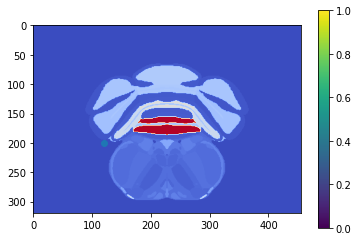

In [34]:
import matplotlib.pyplot as plt
plt.imshow(cell[520], cmap='coolwarm');
plt.scatter(120, 200)
plt.colorbar()  # Add color bar
plt.show()

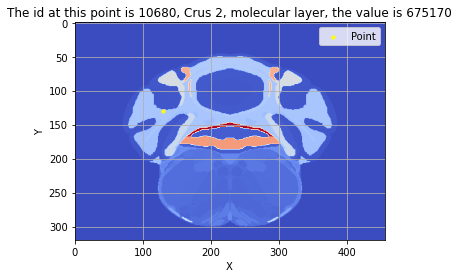

10680 Crus 2, molecular layer value 675170 ( 500 130 130 )


In [35]:
import matplotlib.pyplot as plt
z = 500
plt.imshow(cell[z], cmap='coolwarm');
# Define the coordinates
x = 130
y = 130

name = region_map.get(annotation[z,x,y], "name", with_ascendants=False)

plt.scatter(x, y, color='yellow', label='Point', s=10)
# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'The id at this point is {annotation[z,x,y]}, {name}, the value is {cell[z,x,y]}')
# Show the plot
plt.legend()
plt.grid(True)
plt.show()
print(annotation[z,x,y], name, "value", cell[z,x,y],"(", z, x, y, ")")

 0s:
- 269 Posterolateral visual area, layer 2/3 value 0 ( 85 80 400 )
- 621 Motor nucleus of trigeminal
- 326 superior cerebelar peduncles value 0 ( 170 180 400 )
- 313 Midbrain value 0 ( 150 275 400 )
- 1052 Pedunculopontine nucleus value 0 ( 160 170 400 )


 ___
 HIGH:
- 867 Parabrachial nucleus
- 1052 Pedunculopontine nucleus value 0 ( 154 273 400 )


### Continue

for the next cell the variable cell should contain total cell densities

In [36]:
# Assertion on total cell densities
cell_dens = np.sum(cell) / whole_brain_annotation_dens# * voxel_volume
cell_dens_diff = abs(cell_dens_litt - cell_dens)
print("\nAssertion on total cell densities (/mm^3)")
print_range_bar(cell_dens, cell_dens_litt - cell_dens_tolerance, cell_dens_litt + cell_dens_tolerance)
assertion_message = "total cell densities out of literature range"
z_score_assertion(cell_dens, cell_dens_litt - cell_dens_tolerance, cell_dens_litt + cell_dens_tolerance, assertion_message)



Assertion on total cell densities (/mm^3)
Range: [                                 *      ] 243243  | z-score = 0.65 |  -17.5% [180012, 256529] +17.5%
Validated


In [37]:

# Assertion on total neuron densities
neuron_dens = np.sum(neuron) / whole_brain_annotation_dens # * voxel_volume
neuron_dens_diff = abs(neuron_dens_litt - neuron_dens)
print("\nAssertion on total neuron densities (/mm^3)")
print_range_bar(neuron_dens, neuron_dens_litt - neuron_dens_tolerance, neuron_dens_litt + neuron_dens_tolerance)
assertion_message = "total neuron densities out of literature range"
z_score_assertion(neuron_dens, neuron_dens_litt - neuron_dens_tolerance, neuron_dens_litt + neuron_dens_tolerance, assertion_message)




Assertion on total neuron densities (/mm^3)
Range: [                      *                 ] 143052  | z-score = 0.09 |  -16.2% [118096, 163919] +16.2%
Validated


In [38]:
# Assertion on total glia densities
glia_dens = np.sum(glia) / whole_brain_annotation_dens # * voxel_volume
glia_dens_diff = abs(glia_dens_litt - glia_dens)
print("\nAssertion on total glia densities (/mm^3)")
print_range_bar(glia_dens, glia_dens_litt - glia_dens_tolerance, glia_dens_litt + glia_dens_tolerance)
assertion_message = "total glia densities out of literature range"
z_score_assertion(glia_dens, glia_dens_litt - glia_dens_tolerance, glia_dens_litt + glia_dens_tolerance, assertion_message)



Assertion on total glia densities (/mm^3)
Range: [                 *                      ] 74844  | z-score = -0.16 |  -19.9% [61917, 92610] +19.9%
Validated


In [39]:
# Assertion on total sum of inhibitory + excitatory neuron densities
#exci_inhib_sum = VoxelData.load_nrrd(excitatory_path_list[0]).raw
#print("\nadding initialization 1/" + str(len(excitatory_path_list)))
# for i in range (1, len(excitatory_path_list)):
#     print("+ adding file " + str(i+1) + "/" + str(len(excitatory_path_list)))
#     exci_inhib = VoxelData.load_nrrd(excitatory_path_list[i]).raw
#     exci_inhib_sum += exci_inhib
exci_inhib_sum_sum = np.sum(exci_inhib_sum) / whole_brain_annotation_dens # * voxel_volume
diff_exci_inhib_sum = abs(neuron_dens_litt - exci_inhib_sum_sum)
print("\nAssertion on sum of inhibitory + excitatory neuron densities (/mm^3)")
print_range_bar(exci_inhib_sum_sum, neuron_dens_litt - neuron_dens_tolerance, neuron_dens_litt + neuron_dens_tolerance)
# print("/!\ Data not available")
assertion_message = "sum of inhibitory + excitatory neuron densities out of literature range"
z_score_assertion(exci_inhib_sum_sum, neuron_dens_litt - neuron_dens_tolerance, neuron_dens_litt + neuron_dens_tolerance, assertion_message)



Assertion on sum of inhibitory + excitatory neuron densities (/mm^3)
Range: [                     *                  ] 142677  | z-score = 0.07 |  -16.2% [118096, 163919] +16.2%
Validated


In [40]:
# Assertion on total inhibitory neuron densities
inhi_dens = np.sum(gad) / whole_brain_annotation_dens # * voxel_volume
diff_inhi = abs(inhibitory_neuron_dens_litt - inhi_dens)
print("\nAssertion on total inhibitory neuron densities (/mm^3)")
print("/!\ Tolerance set to default for neuron density")
# print("/!\ Default tolerance increased by a factor of 2.5")
print_range_bar(inhi_dens, inhibitory_neuron_dens_litt - inhibitory_neuron_dens_tolerance, inhibitory_neuron_dens_litt + inhibitory_neuron_dens_tolerance)
# assert (diff_inhi <= inhibitory_neuron_dens_tolerance * 2.5) #, f"diff_ini = " + str(diff_inhi) + "   |   tolerence = " + str(inhibitory_neuron_dens_tolerance)
assertion_message = "total inhibitory neuron densities out of literature range"
z_score_assertion(inhi_dens, inhibitory_neuron_dens_litt - inhibitory_neuron_dens_tolerance, inhibitory_neuron_dens_litt + inhibitory_neuron_dens_tolerance, assertion_message)




Assertion on total inhibitory neuron densities (/mm^3)
/!\ Tolerance set to default for neuron density
Range: [                     *                  ] 28835  | z-score = 0.05 |  -16.0% [24017, 33165] +16.0%
Validated


In [30]:
# Assertion on total astrocyte densities
print("\nAssertion on total astrocyte densities")
print("/!\ Litterature data not available")

# Assertion on total microglia densities
print("\nAssertion on total microglia densities")
print("/!\ Litterature data not available")

# Assertion on total oligodendrocyte density
print("\nAssertion on total oligodendrocyte densities")
print("/!\ Data not available")




Assertion on total astrocyte densities
/!\ Litterature data not available

Assertion on total microglia densities
/!\ Litterature data not available

Assertion on total oligodendrocyte densities
/!\ Data not available
